In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
import xgi
from collections import defaultdict
from itertools import combinations

from hyperfunctions import *
from modularity_functions import *

In [2]:
edge_list_1 = [['a','b'],['c','d'],['a','b','c'],['a','b','d'],['e','f','g'],
               ['a','b','d','e'],['c','f','d','a'],['f','g'],['e','g','d'],['g','e'],
               ['e','f'],['a','h'],['i','h','j','k'],['j','e','g'],['i','j','k','b'],
               ['d','k','e','j'],['k','h'],['l','m','n'],['n','e','f'],['l','h','g'],['m','c']]

In [3]:
H = xgi.Hypergraph(edge_list_1)
nodes_list = list(H.nodes)

print(len(H.nodes), len(H.edges))

# Remove singletons
H.remove_edges_from(H.edges.singletons())
print(len(H.nodes), len(H.edges))

14 21
14 21


In [4]:
derivative = derivative_list(H)

In [5]:
method = "average"

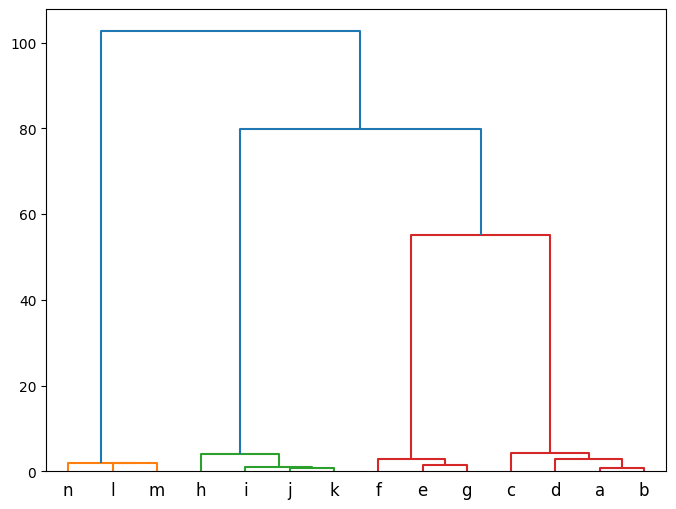

In [6]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

Z = hierarchy.linkage(derivative, method)
dn = hierarchy.dendrogram(Z, labels = nodes_list, orientation='top', count_sort='ascending', ax=ax)

plt.show()

## General (us)

In [7]:
h_cut, num_fusion = height_based_cut(Z)

In [8]:
cuttree = hierarchy.cut_tree(Z, height = h_cut)
Communities_dict = {}
for cont, i in enumerate(nodes_list):
    Communities_dict[i] = cuttree[cont][0]

In [9]:
print(Communities_dict)

{'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 1, 'f': 1, 'g': 1, 'h': 2, 'i': 2, 'j': 2, 'k': 2, 'l': 3, 'm': 3, 'n': 3}


In [10]:
Num_communities = len(set(Communities_dict.values()))
print(Num_communities)

4


In [11]:
grouped_dict = defaultdict(list)
for key, val in Communities_dict.items():
    grouped_dict[val].append(key)

Communities_list = list(grouped_dict.values())
print(Communities_list)

[['a', 'b', 'c', 'd'], ['e', 'f', 'g'], ['h', 'i', 'j', 'k'], ['l', 'm', 'n']]


## Modularity (us)

In [12]:
A, G, mapping = reduced_adjacency_matrix(H)

In [13]:
Modularity = []
for n in range(1,len(H.nodes)):
    
    if n % 50 == 0:
        print(f'-- {n/len(H.nodes)}% --')
    
    cuttree = hierarchy.cut_tree(Z, n_clusters = n)
    Communities_dict = {}

    for cont, i in enumerate(nodes_list):
        Communities_dict[i] = cuttree[cont][0]
    
    # Get the list of communities
    grouped_dict = defaultdict(list)
    for key, val in Communities_dict.items():
        grouped_dict[val].append(key)

    Communities_list = list(grouped_dict.values())
    #print(Communities_list)
        
    q = nx.community.modularity(G, Communities_list)
    
    Modularity.append(q)

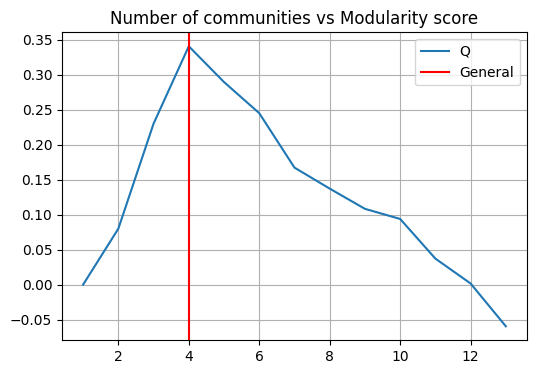

In [14]:
plt.figure(figsize=(6,4))
plt.title("Number of communities vs Modularity score")
plt.plot(range(1,len(H.nodes)), Modularity, label='Q')
plt.grid()
plt.axvline(Num_communities, color='r', label='General')

plt.legend()

*Conclusion*: the general method coincides with our modularity maximization in this example

In [15]:
m = max(Modularity)
num_fusion = [i for i, j in enumerate(Modularity) if j == m]
index_max = num_fusion[0]

print(f'Number of communities maximizing the modularity is: {index_max},')
print(f'with modularity: {m}')

Number of communities maximizing the modularity is: 3,
with modularity: 0.34055555555555556


In [16]:
communities_dict = communities(H, derivative, method, n_clusters=index_max)

nodeset_list = []
for nodeset in communities_dict.values():
    nodeset_list.append(nodeset)

print(nodeset_list)

[{'g', 'f', 'b', 'c', 'a', 'd', 'e'}, {'h', 'i', 'k', 'j'}, {'n', 'l', 'm'}]


## Modularity (Kumar)

In [17]:
clusters = IRMM_algorithm(H, tol=1e-3)
Communities_K = []
for comm in clusters:
    Community_K = []
    for node in comm:
        Community_K.append(mapping[node])
    Communities_K.append(Community_K)

print(Communities_K)

q = nx.community.modularity(G,Communities_K)
print(f'The modularity for this partition is: {q}')

It converge after 16 iterations
[['a', 'b', 'c', 'd', 'm'], ['e', 'f', 'g', 'l', 'n'], ['i', 'j', 'k', 'h']]
The modularity for this partition is: 0.32944444444444443


## Modularity (Kaminski)